# TMSMM - Sentiment Stock Prediction Apple
by Tomasz Starakiewicz and Dustin Pacholleck

Disclaimer: The notebook was run on kaggle. In the included data file, only the data for Apple is found due to the size of the original dataset (>2.5 GB).

### Setup

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import concurrent.futures

/kaggle/input/financial-news/articles.csv
/kaggle/input/financial-news/links.csv


In [2]:
import torch

# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("Using CPU")

Using CPU


In [3]:
# Load the FinBert model
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert", padding=True, truncation=True, return_tensors="pt",max_length=512)
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert").to(device)

### Data

In [4]:
# Load the financial news dataset and do some basic transformations
import pandas as pd

df = pd.read_csv('/kaggle/input/financial-news/articles.csv')
df_links = pd.read_csv('/kaggle/input/financial-news/links.csv')
df = df.merge(df_links, left_on ='source_url', right_on= 'link')
# # Reduce the number of observations
# df.drop_duplicates(subset='text', inplace = True)
# # Draw random sample of 20%
# df = df.sample(frac=0.1, random_state = 42)
df['date'] = pd.to_datetime(df.date).dt.tz_localize("EST")
df['date_utc'] = df.date.dt.tz_convert("UTC")
df['year'] = df['date_utc'].dt.year
df['month'] = df['date_utc'].dt.month
df['release']= df['date'].dt.date
df.dropna(inplace = True)
df.rename(columns={'instrument':'ticker'}, inplace=True)
# df = df[df['year'] >= 2022]

/opt/conda/lib/python3.7/site-packages/dateutil/parser/_parser.py:1212: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


#### Data Exploration

In [5]:
df.columns

Index(['date', 'headline', 'ticker', 'source_url', 'text', 'link', 'source',
       'date_utc', 'year', 'month', 'release'],
      dtype='object')

In [6]:
print('Number of unique articles: ' + str(len(df.text.unique())))

Number of unique articles: 176224


In [7]:
# get random article
import random
random.seed(5)

for i in random.sample(range(0, len(df)-1),1):
    print(df.text[i])
    print('___________________________________________________________________________________')

Investing.com – Japan stocks were higher after the close on Wednesday, as gains in the  Retail ,  Gas & Water  and  Transport  sectors led shares higher. At the close in Tokyo, the  Nikkei 225  gained 0.57%. The best performers of the session on the  Nikkei 225  were   JFE Holdings, Inc.   (T: 5411 ), which rose 5.88% or 144.0 points to trade at 2595.0 at the close. Meanwhile,   Yamaha Corp.   (T: 7951 ) added 5.16% or 200.0 points to end at 4075.0 and   Kobe Steel, Ltd.   (T: 5406 ) was up 4.25% or 43.0 points to 1055.5 in late trade. The worst performers of the session were   Tokyo Electron Ltd.   (T: 8035 ), which fell 5.77% or 1285.0 points to trade at 20995.0 at the close.   Dainippon Screen Mfg. Co., Ltd.   (T: 7735 ) declined 5.03% or 540.0 points to end at 10185.0 and   Shin-Etsu Chemical Co., Ltd.   (T: 4063 ) was down 3.82% or 475.0 points to 11945.0. Rising stocks outnumbered declining ones on the Tokyo Stock Exchange by 2214 to 1086 and 196 ended unchanged. Shares in JFE Ho

In [8]:
# check by ticker
df.ticker.value_counts()

US500      15005
DJI        12005
IXIC        9976
CL          9500
AAPL        9389
           ...  
GXG            1
ICOL           1
ICVX           1
600513         1
CHF/HUF        1
Name: ticker, Length: 17467, dtype: int64

In [9]:
# check by source
df.source.value_counts()

By Investing.com                   679941
By Reuters                         232987
By Seeking Alpha                   108848
By Bloomberg                        16648
By StockNews                         6400
By International Business Times      1927
By Business Insider                  1048
By Money Show                         234
By FinanceMagnates                     40
By Bloomberg_video                      2
By Cointelegraph                        1
Name: source, dtype: int64

In [10]:
# set ticker of interest
tickerSymbol = "AAPL"

In [11]:
# filter df for ticker
df = df[df['ticker']==tickerSymbol]

In [12]:
df.drop_duplicates(subset='text', keep='first', inplace=True)

In [13]:
# check by ticker
df.ticker.value_counts()

AAPL    9366
Name: ticker, dtype: int64

In [14]:
# check by year
df.year.value_counts()

2022    1702
2021    1558
2018    1515
2020    1316
2019    1298
2017    1146
2016     421
2015     274
2014     136
Name: year, dtype: int64

In [15]:
df.to_csv('/kaggle/working/aapl_dfInput.csv')

#### Preprocessing

In [16]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import PlaintextCorpusReader

nltk.download('stopwords')
nltk.download('punkt')
# nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
financial_stop_words = ['stocks', 'shares', 'market', 'trading', 'investment', 'investing', 
                            'investor', 'fund', 'funds', 'dividend', 'dividends', 'equity', 
                            'portfolio', 'option', 'options', 'commodity', 'commodities', 'currency', 
                            'currencies', 'bond', 'bonds', 'mutual', 'exchange', 'security', 'securities', 
                            'call', 'puts', 'price', 'prices', 'buy', 'sell', 'bullish', 'bearish', 'bull', 
                            'bear', 'trader', 'traders', 'broker', 'brokers', 'yield', 'futures', 'contract', 
                            'contracts', 'index', 'indices', 'hedge', 'hedging', 'strike', 'put', 'call', 'bid', 
                            'ask', 'spread', 'liquidity', 'derivatives', 'option', 'options', 'futures', 'forward', 
                            'swaps', 'margin', 'short', 'long', 'reuters', 'bloomberg', 'investing', 'com', 'apple', 
                            'aapl', 'analysts','nasdaq', 'dtype', 'dow', 'jones', 'stock' ]

stop_words.update(financial_stop_words)

def preprocess_text(text):

    # Remove special characters and convert to lowercase
    text = re.sub(r"[^a-zA-Z0-9]+", ' ', text).lower()
    # Tokenize the text
    tokens = nltk.word_tokenize(text)
    # Remove stop words
    tokens = [token for token in tokens if token not in stop_words]
    text = " ".join(tokens)
    return text
    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    return ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

df['processed_text'] = df['text'].apply(preprocess_text)
df['processed_headline'] = df['headline'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [17]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt 
# Create wordclouds 
def createWordCloud(df):
    wordcloud = WordCloud(
                #stopwords = stop_words,
                background_color='black',
                width=3000,
                height=2500
                ).generate(' '.join(df))
    return wordcloud

In [18]:
# generate wordcloud for before and after preprocessing
cloud_pre = createWordCloud(df['headline'])
cloud_post= createWordCloud(df['processed_headline'])

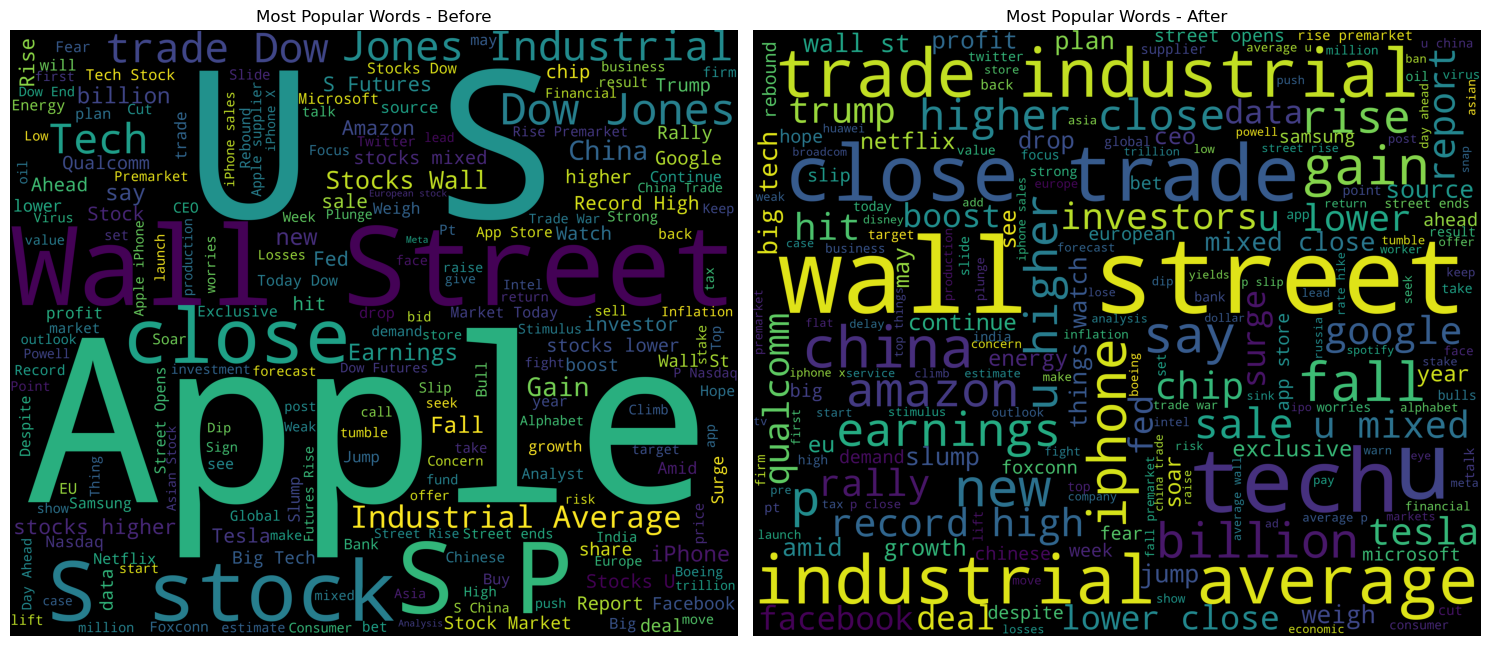

In [19]:
# Display worldclouds
fig, axs = plt.subplots(1,2)
fig.set_figheight(15)
fig.set_figwidth(15)
axs[0].imshow(cloud_pre)
axs[0].axis('off')
axs[0].set_title('Most Popular Words - Before')
axs[1].imshow(cloud_post)
axs[1].axis('off')
axs[1].set_title('Most Popular Words - After')
fig.tight_layout()
plt.show()

### Topic Modelling
The here present approach is based on Dhuriya (2021). 

In [21]:
import gensim
from gensim.utils import simple_preprocess

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

data = df['processed_headline'].values.tolist()
data_words = list(sent_to_words(data))

In [22]:
# Build the bigram
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

In [23]:
# Form Bigrams
data_words_bigrams = make_bigrams(data_words)

In [24]:
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(data_words_bigrams)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [25]:
# after trying several approaches, 3 seemed optimal
num_topics = 3

lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=0.01,
                                           eta=0.9)

from pprint import pprint

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.040*"trade" + 0.037*"close" + 0.035*"industrial" + 0.035*"average" + '
  '0.021*"iphone" + 0.016*"higher" + 0.013*"lower" + 0.013*"sales" + '
  '0.010*"mixed" + 0.009*"profit"'),
 (1,
  '0.040*"wall" + 0.032*"street" + 0.022*"tech" + 0.012*"trade" + '
  '0.011*"lower" + 0.011*"record" + 0.010*"earnings" + 0.010*"higher" + '
  '0.010*"fed" + 0.008*"ahead"'),
 (2,
  '0.008*"china" + 0.008*"billion" + 0.008*"says" + 0.007*"new" + 0.007*"tax" '
  '+ 0.007*"amazon" + 0.007*"qualcomm" + 0.006*"eu" + 0.005*"tech" + '
  '0.005*"deal"')]


In [26]:
 !pip install pyLDAvis==3.3.1
import pyLDAvis.gensim_models as gensimvis
import pickle 
import pyLDAvis

# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join('/kaggle/working/ldavis_tuned_'+str(num_topics))

# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)

# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared, '/kaggle/working/ldavis_tuned_'+ str(num_topics) +'.html')

LDAvis_prepared

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 10.9 MB/s eta 0:00:0000:010:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136882 sha256=0dd83e74f0ea0bcadc7add2b5062a87133f869cf1ca674fe7750dec55a1643ef
  Stored in directory: /root/.cache/pip/wheels/24/77/75/7b204c1e1ddab550803cb58394ba68efddec24a3fe4dd80e85
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2344 sha256=9e2cf93d78b191eee5bf39d546cbd5785e5d02f27d6b798932d8b6ad9bd5211f
  Stored in directory: /root/.cache/pip/wheels/15/9a/b1/2478e73a520d596fab614693f5cd1beef4ba3db737bed1ac7d
Successfully built pyLDAvis sklearn
  Attempting uninstall: pyLDAvis
    Found existing installation: pyLDAvis 3.2.2
    Uninstalling pyLDAvis-3.2.2:
      Successfu

/opt/conda/lib/python3.7/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.173292 -0.005949       1        1  41.170862
2      0.092622 -0.126413       2        1  40.989786
0      0.080670  0.132362       3        1  17.839351, topic_info=            Term         Freq        Total Category  logprob  loglift
176         wall  1022.000000  1022.000000  Default  30.0000  30.0000
139        trade   757.000000   757.000000  Default  29.0000  29.0000
175       street   820.000000   820.000000  Default  28.0000  28.0000
45         close   482.000000   482.000000  Default  27.0000  27.0000
1259  industrial   392.000000   392.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
1336      second    31.958352    72.614284   Topic3  -5.8563   0.9030
316     earnings    46.453014   304.370827   Topic3  -5.4823  -0.1560
183         says    43.146861   244.052024   Topic3  -5.5561  -0.0090
29         china    39.834640   437.580232   Topic3  -5.6360  -0.6728
1026       first    31.955083   119.766351   Topic3  -5.8564   0.4026

[187 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
371       1  0.798283    ahead
371       2  0.003801    ahead
371       3  0.197670    ahead
1395      1  0.088398  airpods
1395      2  0.088398  airpods
...     ...       ...      ...
108       2  0.018779    worst
108       3  0.018779    worst
1506      1  0.968467   yields
1506      2  0.018273   yields
1506      3  0.018273   yields

[429 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1])

### Modelling
The here presented approach is inspired by ‘FF Project FinBERT’ (n.d.).

#### Sentiment Prediction

In [27]:
from tqdm import tqdm
day_data = {}
total = df['release'].nunique()
for i in tqdm(df['release'].unique()):
    day_data[i] = df.loc[(df['release'] == i)]['processed_headline'].tolist()

100%|██████████| 2121/2121 [00:03<00:00, 563.89it/s]


In [28]:
# Get next/previous business day in case of holiday
import datetime 
import holidays 

ONE_DAY = datetime.timedelta(days=1)
HOLIDAYS_US = holidays.US()

def next_business_day(dateString):
    datetimeObj = datetime.datetime.strptime(dateString, '%Y-%m-%d')
    next_day = datetimeObj + ONE_DAY
    while next_day.weekday() in holidays.WEEKEND or next_day in HOLIDAYS_US:
        next_day += ONE_DAY
    return next_day

def prev_business_day(dateString):
    datetimeObj = datetime.datetime.strptime(dateString, '%Y-%m-%d')
    prev_day = datetimeObj - ONE_DAY
    while prev_day.weekday() in holidays.WEEKEND or prev_day in HOLIDAYS_US:
        prev_day -= ONE_DAY
    return prev_day

In [31]:
import torch.nn.functional as F
import numpy as np
def pred_sentiment(doc):
    with torch.no_grad():
        tokens = tokenizer(doc,padding=True,truncation=True,max_length=512,return_tensors="pt")
        tokens.to(device)
        outputs = model(**tokens)
        predictions = F.softmax(outputs.logits, dim=-1)
        predictions.to(device)
    return predictions.detach().cpu().numpy()

def avg_sentiment_day(sentences):
    posAvg, negAvg, neuAvg = 0, 0, 0
    sentiments = pred_sentiment(sentences)
    sentiments = np.mean(sentiments, axis=0)
    posAvg=sentiments[0]
    negAvg=sentiments[1]
    neuAvg=sentiments[2]
    return {'numArticles': len(sentences), 'pos': posAvg, 'neg': negAvg, 'neu' : neuAvg}

In [32]:
# get avg sentiment scores per day
sentimentPerDay = {}
for i in tqdm(day_data):
    scores = avg_sentiment_day(day_data[i])
    sentimentPerDay[i] = scores

100%|██████████| 2121/2121 [04:58<00:00,  7.10it/s]


In [33]:
# other way for generating sentiment to visulize wordclouds
from transformers import pipeline
classifier = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)

def gen_sentiment():
    news_label_and_scores = classifier(list(df['processed_headline']))
    labels=[pred['label'] for pred in news_label_and_scores]
    scores=[pred['score'] for pred in news_label_and_scores]
    df['sentiment'] = labels
    df['sentiment_score'] = scores
    
gen_sentiment()

In [34]:
# Visualize Sentiments using Wordclouds 
df_neg = df[df['sentiment']=='negative']
df_pos = df[df['sentiment']=='positive']
df_neu = df[df['sentiment']=='neutral']

cloud_neg = createWordCloud(df_neg['processed_headline'])
cloud_pos = createWordCloud(df_pos['processed_headline'])
cloud_neu = createWordCloud(df_neu['processed_headline'])

/opt/conda/lib/python3.7/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/conda/lib/python3.7/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/opt/conda/lib/python3.7/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt/conda/lib/python3.7/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/opt

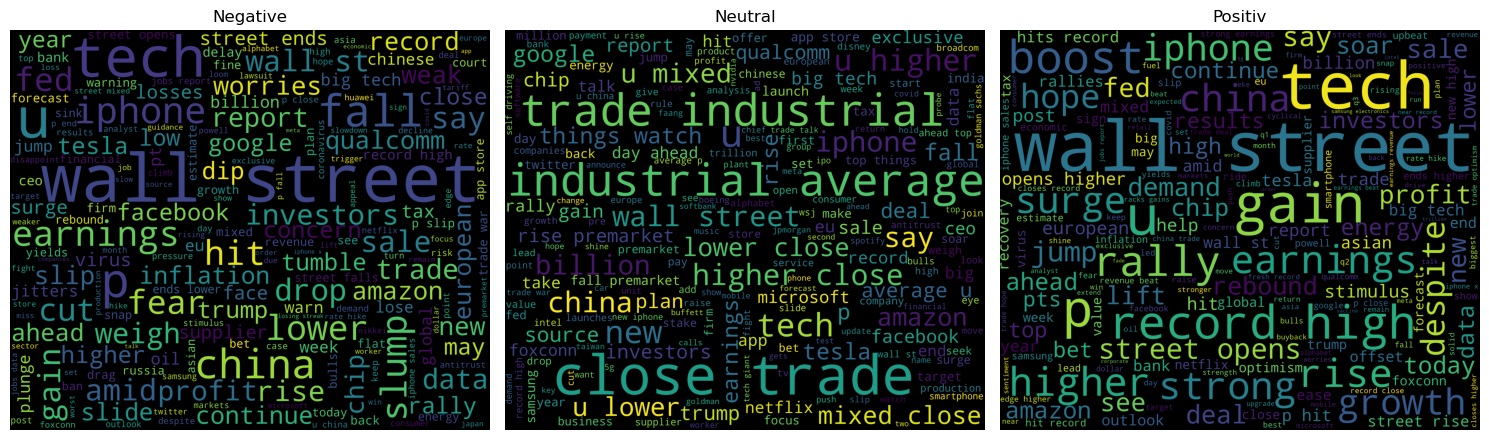

Number of Articles
Negative: 2891 30.87%
Neutral: 4837 51.64%
Positiv: 1638 17.49%


In [35]:
# Display Wordclouds
fig, axs = plt.subplots(1,3)
fig.set_figheight(15)
fig.set_figwidth(15)
axs[0].imshow(cloud_neg)
axs[0].axis('off')
axs[0].set_title('Negative')
axs[1].imshow(cloud_neu)
axs[1].axis('off')
axs[1].set_title('Neutral')
axs[2].imshow(cloud_pos)
axs[2].axis('off')
axs[2].set_title('Positiv')
fig.tight_layout()
plt.show()

print('Number of Articles')
print('Negative: ' + str(len(df_neg)) + ' ' + str(round(len(df_neg)/len(df)*100,2)) + '%')
print('Neutral: ' + str(len(df_neu)) + ' ' + str(round(len(df_neu)/len(df)*100,2)) + '%')
print('Positiv: ' + str(len(df_pos)) + ' ' + str(round(len(df_pos)/len(df)*100,2)) + '%')

#### Financial Data

In [36]:
!pip install yfinance
import yfinance as yf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 1.4 MB/s eta 0:00:00a 0:00:01


In [37]:
data = []
ticker = yf.Ticker(tickerSymbol)
fin_data = ticker.history(period="max")
for i in tqdm(sentimentPerDay):
    start = i.strftime("%Y-%m-%d")
    prevDay = prev_business_day(start).strftime("%Y-%m-%d")
    nextDay = next_business_day(start).strftime("%Y-%m-%d")
    try:
        prevDay = fin_data.loc[prevDay]
        nextDay = fin_data.loc[nextDay]
        data.append([start, sentimentPerDay[i]['numArticles'], sentimentPerDay[i]['neu'], sentimentPerDay[i]['pos'], sentimentPerDay[i]['neg'], prevDay['Close'], nextDay['Open']])
    except:
        pass

100%|██████████| 2121/2121 [00:02<00:00, 899.64it/s]


In [38]:
df_prep = pd.DataFrame(columns =['date','numArticles', 'neutral', 'positive','negative','prev_close', 'next_open'], data=data)

In [39]:
# Check propotions of the dataframe by year
pd.to_datetime(df_prep['date'], format='%Y-%m-%d').dt.year.value_counts()/len(df_prep)*100

2018    13.653663
2021    13.606089
2022    13.415794
2019    13.225500
2020    13.035205
2017    12.178877
2016     8.991437
2015     7.659372
2014     4.234063
Name: date, dtype: float64

In [40]:
# save preparated df for predictions
df_prep.to_csv('/kaggle/working/preped_data.csv', index = False)

#### Predicting Stock Prices

In [41]:
df_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2102 entries, 0 to 2101
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         2102 non-null   object 
 1   numArticles  2102 non-null   int64  
 2   neutral      2102 non-null   float32
 3   positive     2102 non-null   float32
 4   negative     2102 non-null   float32
 5   prev_close   2102 non-null   float64
 6   next_open    2102 non-null   float64
dtypes: float32(3), float64(2), int64(1), object(1)
memory usage: 90.4+ KB


In [42]:
df_prep_sorted = df_prep.sort_values('date')

In [43]:
# Split df by year since 2022 has 13% of articles
train = df_prep_sorted[df_prep_sorted['date']<'2022-01-01']
X_train = train[['numArticles','neutral', 'positive', 'negative', 'prev_close']]
y_train = train['next_open']

test = df_prep_sorted[df_prep_sorted['date']>='2022-01-01']
X_test= test[['numArticles','neutral', 'positive', 'negative', 'prev_close']]
y_test= test['next_open']

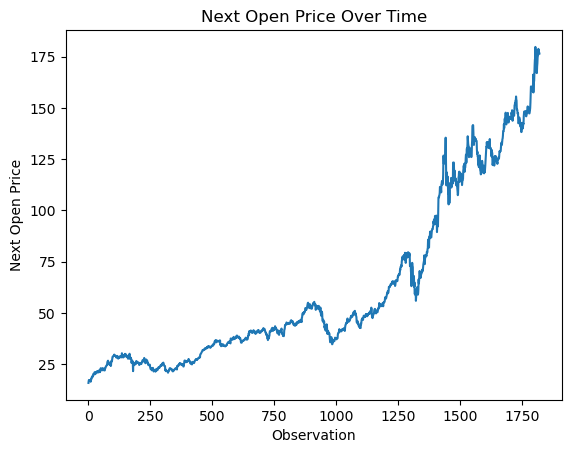

In [44]:
# check open prices in train df
plt.plot(y_train.values)
plt.title('Next Open Price Over Time')
plt.xlabel('Observation')
plt.ylabel('Next Open Price')
plt.show()

In [45]:
from sklearn.pipeline import Pipeline # Pipeline
from sklearn.pipeline import make_pipeline # Pipeline

def model_pipeline(model):
    pipeline = make_pipeline(model)
    return pipeline

In [46]:
# Setup for model evaluation

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error # Evaluation Metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt 

evaluate = pd.DataFrame(columns=['model_name',
                                 'MAE', 
                                 'MSE',
                                 'RMSE',
                                 'MAPE',
#                                  'R2',
                                ])

def model_eval(model_name, y_pred, evaluate):
    evaluate = evaluate.append({'model_name':model_name,
                               'MAE':mean_absolute_error(y_test, y_pred),
                               'MSE':mean_squared_error(y_test, y_pred),
                                'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
                               'MAPE':mean_absolute_percentage_error(y_test,y_pred)
#                                'R2':r2_score(y_test,y_pred)},ignore_index=True
                               }, ignore_index = True)
    return evaluate

def viz_eval(y_pred, label):
    x_ax = range(len(y_pred))
    plt.scatter(x_ax, y_test, s=5, color="blue", label="Original")
    plt.plot(x_ax, y_pred, lw=0.8, color="red", label=label)
    plt.legend()
    plt.show()

##### Random Forest with Sentiment

In [47]:
from sklearn.ensemble import RandomForestRegressor # RandomForest

rf= RandomForestRegressor(n_jobs=-1,random_state = 42)
param_grid = {}
rf_model_base = model_pipeline(rf)
rf_cv_base = GridSearchCV(rf_model_base, param_grid, cv=10, n_jobs=-1, scoring = 'neg_mean_absolute_percentage_error') 
rf_cv_base.fit(X_train,y_train)

pred_rf = rf_cv_base.predict(X_test)

In [48]:
evaluate = model_eval('RF Base Sentiment', pred_rf,evaluate)
evaluate= evaluate.sort_values("MAPE", ignore_index= True)
evaluate

,model_name,MAE,MSE,RMSE,MAPE
0,RF Base Sentiment,3.308666,17.089823,4.133984,0.021749


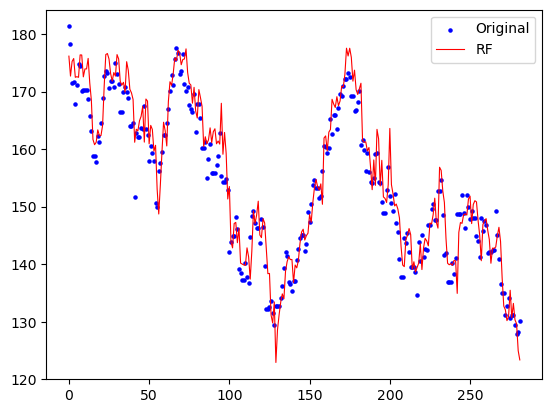

In [49]:
viz_eval(pred_rf, 'RF')

In [50]:
# Randomized Search Grid
max_depth = [int(x) for x in np.linspace(2, 50, num = 10)] # Longest path between the root node and the leaf node
max_depth.append(None)
min_samples_split = [int(x) for x in np.linspace(2, 100, num = 10)] # Minimum number of samples required to split a node
max_leaf_nodes = [int(x) for x in np.linspace(2, 100, num = 10)]
max_leaf_nodes.append(None)
min_samples_leaf = [int(x) for x in np.linspace(1, 100, num = 10)] # Minimum number of samples required at each leaf node
n_estimators = [int(x) for x in np.linspace(start = 25, stop = 600, num = 10)] # Number of trees in random forest
max_samples = [float(x) for x in np.linspace(0.1, 1, num = 10)]
max_samples.append(None)
max_features = ['auto', 'sqrt'] # Number of features to consider at every split
bootstrap = [True] # Method of selecting samples for training each tree

# Create the random grid
random_grid = {'randomforestregressor__n_estimators': n_estimators,
               'randomforestregressor__max_features': max_features,
               'randomforestregressor__max_depth': max_depth,
               'randomforestregressor__min_samples_split': min_samples_split,
               'randomforestregressor__min_samples_leaf': min_samples_leaf,
               'randomforestregressor__max_leaf_nodes': max_leaf_nodes,
               'randomforestregressor__max_samples': max_samples,
               'randomforestregressor__bootstrap': bootstrap}

In [51]:
%%time
# Define pipeline and train model
rf_model_cv = model_pipeline(rf)
rf_cv_random = RandomizedSearchCV(estimator = rf_model_cv, param_distributions = random_grid, 
                                  n_iter = 25, cv = 5, scoring = 'neg_mean_absolute_percentage_error', 
                                  verbose=0, random_state=42, n_jobs = -1) 
rf_cv_random.fit(X_train,y_train)

CPU times: user 4.09 s, sys: 164 ms, total: 4.25 s
Wall time: 36.9 s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('randomforestregressor',
                                              RandomForestRegressor(n_jobs=-1,
                                                                    random_state=42))]),
                   n_iter=25, n_jobs=-1,
                   param_distributions={'randomforestregressor__bootstrap': [True],
                                        'randomforestregressor__max_depth': [2,
                                                                             7,
                                                                             12,
                                                                             18,
                                                                             23,
                                                                             28,
                                                                             34,
                                              

In [52]:
pred_rf_random = rf_cv_random.predict(X_test)

In [53]:
evaluate = model_eval('RF Random Sentiment', pred_rf_random,evaluate)
evaluate= evaluate.sort_values("MAPE", ignore_index= True)
evaluate

,model_name,MAE,MSE,RMSE,MAPE
0,RF Random Sentiment,3.200636,16.233492,4.029081,0.021079
1,RF Base Sentiment,3.308666,17.089823,4.133984,0.021749


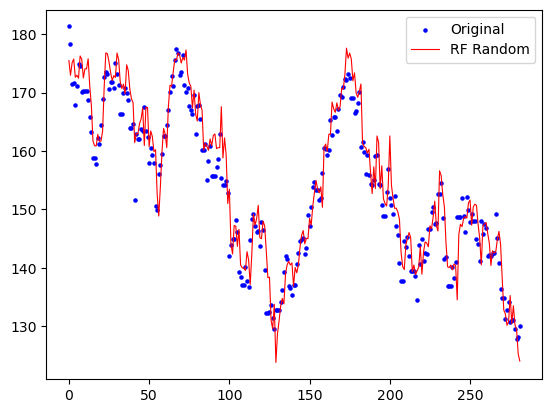

In [54]:
viz_eval(pred_rf_random, 'RF Random')

In [55]:
rf_cv_random.best_params_

{'randomforestregressor__n_estimators': 408,
 'randomforestregressor__min_samples_split': 2,
 'randomforestregressor__min_samples_leaf': 1,
 'randomforestregressor__max_samples': 0.9,
 'randomforestregressor__max_leaf_nodes': None,
 'randomforestregressor__max_features': 'auto',
 'randomforestregressor__max_depth': 34,
 'randomforestregressor__bootstrap': True}

##### Prediction without Sentiment

In [56]:
train = df_prep_sorted[df_prep_sorted['date']<'2022-01-01']
X_train_ref = train[['prev_close']]
y_train_ref = train['next_open']

test = df_prep_sorted[df_prep_sorted['date']>='2022-01-01']
X_test_ref = test[['prev_close']]
y_test_ref = test['next_open']

In [57]:
from sklearn.ensemble import RandomForestRegressor # RandomForest

rf= RandomForestRegressor(n_jobs=-1,random_state = 42)
param_grid = {}
rf_model_ref = model_pipeline(rf)
rf_cv_ref = GridSearchCV(rf_model_ref, param_grid, cv=10, n_jobs=-1, scoring = 'neg_mean_absolute_percentage_error') 
rf_cv_ref.fit(X_train_ref,y_train_ref)

pred_rf_ref = rf_cv_ref.predict(X_test_ref)

In [58]:
evaluate = model_eval('RF Base Ref', pred_rf_ref,evaluate)
evaluate= evaluate.sort_values("MAPE", ignore_index= True)
evaluate

,model_name,MAE,MSE,RMSE,MAPE
0,RF Random Sentiment,3.200636,16.233492,4.029081,0.021079
1,RF Base Ref,3.230220,16.692648,4.085664,0.021351
2,RF Base Sentiment,3.308666,17.089823,4.133984,0.021749


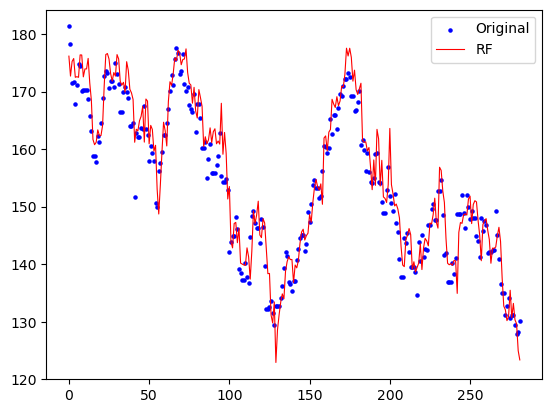

In [59]:
viz_eval(pred_rf, 'RF')

In [60]:
max_depth = [int(x) for x in np.linspace(2, 50, num = 10)] # Longest path between the root node and the leaf node
max_depth.append(None)
min_samples_split = [int(x) for x in np.linspace(2, 100, num = 10)] # Minimum number of samples required to split a node
max_leaf_nodes = [int(x) for x in np.linspace(2, 100, num = 10)]
max_leaf_nodes.append(None)
min_samples_leaf = [int(x) for x in np.linspace(1, 100, num = 10)] # Minimum number of samples required at each leaf node
n_estimators = [int(x) for x in np.linspace(start = 25, stop = 600, num = 10)] # Number of trees in random forest
max_samples = [float(x) for x in np.linspace(0.1, 1, num = 10)]
max_samples.append(None)
max_features = ['auto', 'sqrt'] # Number of features to consider at every split
bootstrap = [True] # Method of selecting samples for training each tree

# Create the random grid
random_grid = {'randomforestregressor__n_estimators': n_estimators,
               'randomforestregressor__max_features': max_features,
               'randomforestregressor__max_depth': max_depth,
               'randomforestregressor__min_samples_split': min_samples_split,
               'randomforestregressor__min_samples_leaf': min_samples_leaf,
               'randomforestregressor__max_leaf_nodes': max_leaf_nodes,
               'randomforestregressor__max_samples': max_samples,
               'randomforestregressor__bootstrap': bootstrap}

In [61]:
%%time
# Define pipeline
rf_model_cv_ref = model_pipeline(rf)
rf_cv_random_ref = RandomizedSearchCV(estimator = rf_model_cv_ref, param_distributions = random_grid, 
                                  n_iter = 25, cv = 5, scoring = 'neg_mean_absolute_percentage_error', 
                                  verbose=0, random_state=42, n_jobs = -1) 
rf_cv_random_ref.fit(X_train_ref,y_train_ref)

CPU times: user 2.08 s, sys: 167 ms, total: 2.25 s
Wall time: 28.4 s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('randomforestregressor',
                                              RandomForestRegressor(n_jobs=-1,
                                                                    random_state=42))]),
                   n_iter=25, n_jobs=-1,
                   param_distributions={'randomforestregressor__bootstrap': [True],
                                        'randomforestregressor__max_depth': [2,
                                                                             7,
                                                                             12,
                                                                             18,
                                                                             23,
                                                                             28,
                                                                             34,
                                              

In [62]:
pred_rf_random_ref = rf_cv_random_ref.predict(X_test_ref)

In [63]:
evaluate = model_eval('RF Random Ref', pred_rf_random_ref,evaluate)
evaluate= evaluate.sort_values("MAPE", ignore_index= True)
evaluate

,model_name,MAE,MSE,RMSE,MAPE
0,RF Random Ref,3.171607,16.144772,4.018056,0.020978
1,RF Random Sentiment,3.200636,16.233492,4.029081,0.021079
2,RF Base Ref,3.230220,16.692648,4.085664,0.021351
3,RF Base Sentiment,3.308666,17.089823,4.133984,0.021749


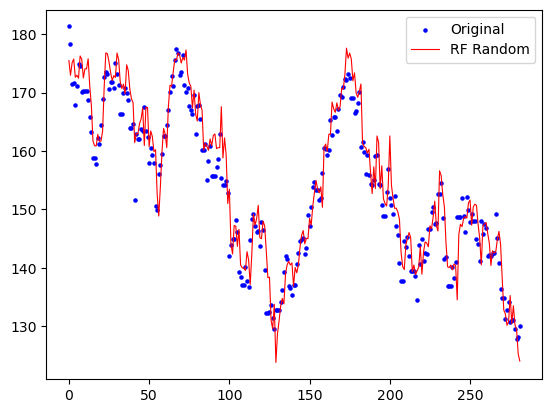

In [64]:
viz_eval(pred_rf_random, 'RF Random')

In [65]:
rf_cv_random.best_params_

{'randomforestregressor__n_estimators': 408,
 'randomforestregressor__min_samples_split': 2,
 'randomforestregressor__min_samples_leaf': 1,
 'randomforestregressor__max_samples': 0.9,
 'randomforestregressor__max_leaf_nodes': None,
 'randomforestregressor__max_features': 'auto',
 'randomforestregressor__max_depth': 34,
 'randomforestregressor__bootstrap': True}